In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last" # all | last | last_expr | none 

In [3]:
# for name in dir():
#     if not name.startswith('_'):
#         del globals()[name]

In [4]:
# ============= Import required packaages ==============
import time

# Import all custom variables and modules
from custom_classes_defs.preprocessing import *
from custom_classes_defs.hed import *

RND_STATE = 247
BATCH_SIZE = 512
keras.utils.set_random_seed(RND_STATE)
from keras.utils import plot_model

INTERACTIVE_SESSION = True

# -------------------------------------------------------

2024-05-10 12:25:06.578328: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-10 12:25:06.578448: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-10 12:25:06.647744: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-10 12:25:06.740735: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# Verify tensorflow/keras versions
print(f"tensorflow version: {tf.__version__}")
print(f"keras version: {keras.__version__}")

# Verify CPU/GPU availability
print(tf.config.list_physical_devices())
NUM_GPU = len(tf.config.list_physical_devices('GPU'))
print(f"Number of GPUs assigned for computation: {NUM_GPU}")

if NUM_GPU:
    # print GPU info
    !nvidia-smi

tensorflow version: 2.15.0
keras version: 2.15.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Number of GPUs assigned for computation: 1
/usr/local/bin/bash: /opt/miniconda3-py311/lib/libtinfo.so.6: no version information available (required by /usr/local/bin/bash)


Fri May 10 12:25:33 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.29.06              Driver Version: 545.29.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe          Off | 00000000:01:00.0 Off |                    0 |
| N/A   35C    P0             102W / 300W |   6377MiB / 81920MiB |     23%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

|   3  NVIDIA A100 80GB PCIe          Off | 00000000:81:00.0 Off |                    0 |
| N/A   28C    P0              40W / 300W |      4MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+----------------------+
|   4  NVIDIA A100 80GB PCIe          Off | 00000000:C1:00.0 Off |                    0 |
| N/A   28C    P0              43W / 300W |      7MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+----------------------+
|   5  NVIDIA A100 80GB PCIe          Off | 00000000:E1:00.0 Off |                    0 |
| N/A   28C    P0              42W / 300W |      4MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+---------

### Data preparation and model configurations

In [6]:
print("{}\n\t{}\n{}".format('='*55,'Data preparation and model configurations', '-'*55))
# Hand-written alphabet images
start = time.time()
if 'letters' not in dir():
    letters = MNIST_letters(
        './data/az_handwritten_alphabets_in_csv_format/A_Z_Handwritten_Data.csv',
    )
    
# # Preprocessing and normalization

# Load data (split ratio = train:val:test = 5:1:4)
(x_train, _), (x_test, _), (x_val, _) = \
    letters.split_data(train_ratio=0.5, val_ratio=0.1)
    # letters.split_data(train_ratio=0.1, val_ratio=0.08)

print("Shape of dataset: {}".format(str(letters.df.shape)))
print("Shape of training data: {}".format(str(x_train.shape)))
print("Shape of validation data: {}".format(str(x_val.shape)))
print("Shape of test data: {}".format(str(x_test.shape))) 

# Create data generator for respective data samples and labels
train_dataset = letters.data_generator(x_train, batch_size=BATCH_SIZE, cache=NUM_GPU) 
val_dataset = letters.data_generator(x_val, batch_size=BATCH_SIZE, cache=NUM_GPU) 
x_test, y_test = letters.data_generator(x_test, as_numpy=True)
        
print("Train Dataset:", train_dataset)
print('...elapsed time: ___{:5.2f} minutes___'.format((time.time()-start) / 60))

	Data preparation and model configurations
-------------------------------------------------------


Shape of dataset: (144013, 784)
Shape of training data: (72006, 28, 28)
Shape of validation data: (14402, 28, 28)
Shape of test data: (57605, 28, 28)


2024-05-10 12:25:55.266955: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79086 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:c1:00.0, compute capability: 8.0


Train Dataset: <CacheDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 28, 28, 1), dtype=tf.uint8, name=None))>
...elapsed time: ___ 0.27 minutes___


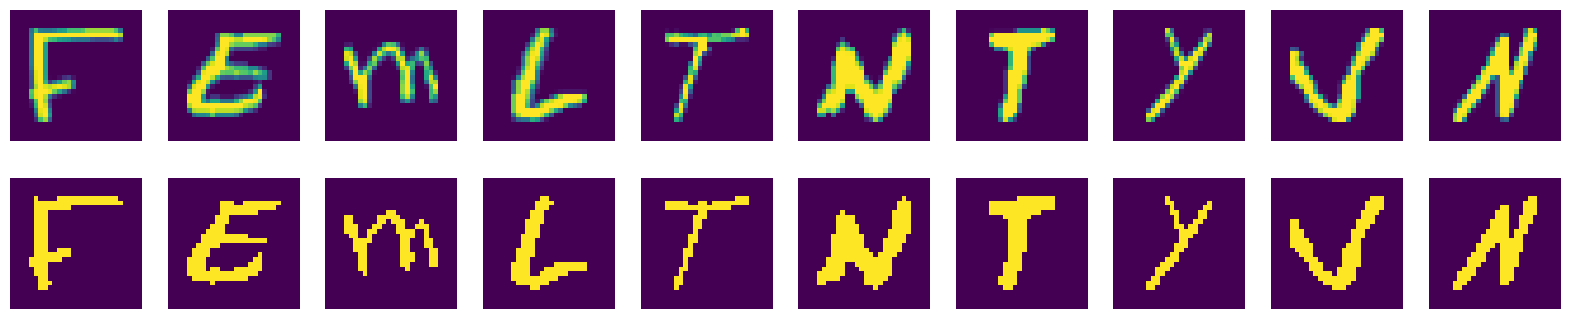

In [7]:
display_sample_images(x_test, y_test, img_shape=(28,28))

In [8]:

# Model configurations
conf = model_config(
    epochs=100,
    batch_size=BATCH_SIZE,
    shuffle=True,
    scaling=1,
    verbose=0,
    save_path='./mnist-letters/hed',
    threshold=letters.threshold,
    pos_label=letters.pos_label,
    new_training_session=True,
    multiple_gpu_device=(NUM_GPU>1),
    train_size=letters.train_size,
    test_size=letters.test_size,
    validation_size=letters.validation_size
)


hed_out = 'output0_'
callbacks = conf.callbacks(
    chkpt_monitor='val_'+hed_out+'f1_score', 
    es_monitor='val_'+hed_out+'loss',
    es_patience=15, 
    lr_monitor='val_'+hed_out+'loss',
    lr_patience=5,
)

conf.set( validation_data=val_dataset,  callbacks=callbacks )
m1 = f1_score(positive_label=letters.pos_label, threshold=letters.threshold)
conf.set(
    'compile',
    metrics= ['accuracy', m1]
)

# conf.double_check(INTERACTIVE_SESSION)
conf.info()

             NUM_GPU: 1
        augmentation: False
        channels_dim: (1, 1)
        compile_args:
                     optimizer: adam
                          loss: binary_crossentropy
                       metrics: accuracy
                              : f1_score(name=f1_score,dtype=float32)
           img_shape: (28, 28)
              labels: ListWrapper([0, 1])
     mixed_precision: None
          model_arch:
                     img_shape: (28, 28)
                   target_size: (28, 28)
                  channels_dim: (1, 1)
                       scaling: 1
                  augmentation: False
 multiple_gpu_device: False
new_training_session: True
           pos_label: 1
           save_path: ./mnist-letters/hed
             scaling: 1
         target_size: (28, 28)
           test_size: 57605
           threshold: 0.5
          train_size: 72006
       training_args:
                        epochs: 100
                    batch_size: 512
                       shuffle

### Build  model 

In [9]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Build model', '-'*55))

if conf.multiple_gpu_device:

    strategy = tf.distribute.MirroredStrategy()
    print(f"Number of devices: {strategy.num_replicas_in_sync}")
    with strategy.scope():
        m_obj = HED2D(model_arch=conf.model_arch)
        model = m_obj.build_model()
        model.compile(**conf.compile_args)

else:

    m_obj = HED2D(model_arch=conf.model_arch)
    model = m_obj.build_model()
    model.compile(**conf.compile_args)


# model.summary()
# keras.utils.plot_model(model, 'm_obj.png',show_shapes=True)
# plot_model(model, 'm_obj.png',show_shapes=True)
num_trainable_weights = sum([np.prod(w.shape) for w in model.trainable_weights])
print(f"Total number of parameters: {model.count_params():,}")
print(f"Total trainable wieghts: {num_trainable_weights:,}")
print(f"Total non-trainable wieghts: {model.count_params()-num_trainable_weights:,}")





	Build model
-------------------------------------------------------
inputs padded by 2 to fit model design


Cropping the output by 2 to fit input...
Cropping the output by 2 to fit input...
Resizing the output to fit input...
Cropping the output by 2 to fit input...
Cropping the output by 2 to fit input...
Cropping the output by 2 to fit input...
Cropping the output by 2 to fit input...
Resizing the output to fit input...
Total number of parameters: 14,716,237
Total trainable wieghts: 7,080,973
Total non-trainable wieghts: 7,635,264


### Train  model



	Train hed model
-------------------------------------------------------
Model training...


2024-05-10 12:26:16.899581: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


2024-05-10 12:26:20.650902: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f000e59d7d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-10 12:26:20.650964: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-05-10 12:26:20.671087: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


I0000 00:00:1715336780.870151 2809935 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


training elapsed time: ___4.99 ___ minutes
...training completed!


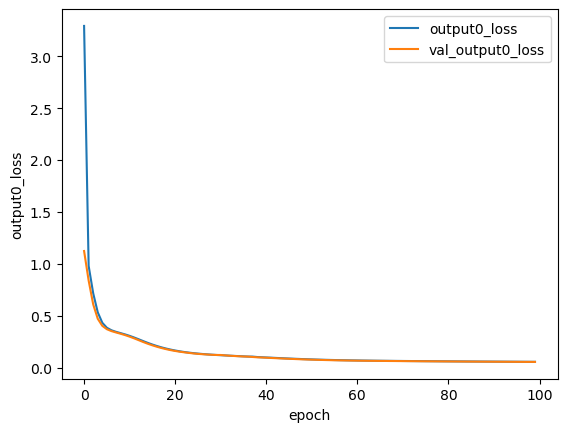

Error writing model_history.pickle!


In [10]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Train {m_obj.Name} model', '-'*55))

model, train_history = \
    conf.execute_training(
        model, 
        data=train_dataset, 
        plot_history=INTERACTIVE_SESSION,
        metrics=[hed_out+'loss', 'val_'+hed_out+'loss']
)


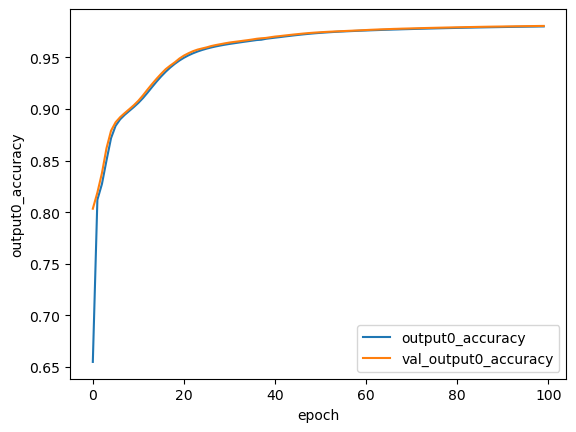

In [11]:
show_convergence(train_history.history, [hed_out+'accuracy','val_'+hed_out+'accuracy'])

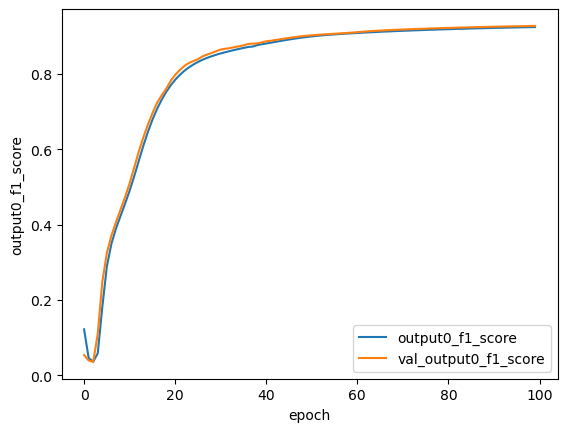

In [12]:
show_convergence(train_history.history, [hed_out+'f1_score','val_'+hed_out+'f1_score'])

### Evaluate and Vizualize

In [13]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Evaluate {m_obj.Name} model', '-'*55))
decoded_imgs = model.predict(x_test)




	Evaluate hed model
-------------------------------------------------------


   1/1801 [..............................] - ETA: 22:00

  13/1801 [..............................] - ETA: 7s   

  24/1801 [..............................] - ETA: 7s

  35/1801 [..............................] - ETA: 8s

  46/1801 [..............................] - ETA: 8s

  57/1801 [..............................] - ETA: 7s

  68/1801 [>.............................] - ETA: 7s

  79/1801 [>.............................] - ETA: 7s

  90/1801 [>.............................] - ETA: 7s

 101/1801 [>.............................] - ETA: 7s

 112/1801 [>.............................] - ETA: 7s

 123/1801 [=>............................] - ETA: 7s

 134/1801 [=>............................] - ETA: 7s

 145/1801 [=>............................] - ETA: 7s

 156/1801 [=>............................] - ETA: 7s

 167/1801 [=>............................] - ETA: 7s

 178/1801 [=>............................] - ETA: 7s

 188/1801 [==>...........................] - ETA: 7s

 198/1801 [==>...........................] - ETA: 7s

 209/1801 [==>...........................] - ETA: 7s

 219/1801 [==>...........................] - ETA: 7s

 230/1801 [==>...........................] - ETA: 7s

 241/1801 [===>..........................] - ETA: 7s

 252/1801 [===>..........................] - ETA: 7s

 263/1801 [===>..........................] - ETA: 7s

 274/1801 [===>..........................] - ETA: 7s

 285/1801 [===>..........................] - ETA: 7s

 296/1801 [===>..........................] - ETA: 7s

 307/1801 [====>.........................] - ETA: 7s

 318/1801 [====>.........................] - ETA: 6s

 329/1801 [====>.........................] - ETA: 6s

 340/1801 [====>.........................] - ETA: 6s

 351/1801 [====>.........................] - ETA: 6s

 362/1801 [=====>........................] - ETA: 6s

 373/1801 [=====>........................] - ETA: 6s

 384/1801 [=====>........................] - ETA: 6s

 395/1801 [=====>........................] - ETA: 6s

 405/1801 [=====>........................] - ETA: 6s

 415/1801 [=====>........................] - ETA: 6s

 425/1801 [======>.......................] - ETA: 6s

 435/1801 [======>.......................] - ETA: 6s

 445/1801 [======>.......................] - ETA: 6s

 456/1801 [======>.......................] - ETA: 6s

 467/1801 [======>.......................] - ETA: 6s

 478/1801 [======>.......................] - ETA: 6s

 489/1801 [=======>......................] - ETA: 6s

 500/1801 [=======>......................] - ETA: 6s

 511/1801 [=======>......................] - ETA: 6s

 522/1801 [=======>......................] - ETA: 6s

 532/1801 [=======>......................] - ETA: 6s

 543/1801 [========>.....................] - ETA: 5s

 554/1801 [========>.....................] - ETA: 5s

 565/1801 [========>.....................] - ETA: 5s

 576/1801 [========>.....................] - ETA: 5s

 587/1801 [========>.....................] - ETA: 5s

 598/1801 [========>.....................] - ETA: 5s

 609/1801 [=========>....................] - ETA: 5s

 620/1801 [=========>....................] - ETA: 5s

 631/1801 [=========>....................] - ETA: 5s

 642/1801 [=========>....................] - ETA: 5s

 654/1801 [=========>....................] - ETA: 5s

 666/1801 [==========>...................] - ETA: 5s

 678/1801 [==========>...................] - ETA: 5s

 689/1801 [==========>...................] - ETA: 5s

 700/1801 [==========>...................] - ETA: 5s

 712/1801 [==========>...................] - ETA: 5s

 724/1801 [===========>..................] - ETA: 5s

 736/1801 [===========>..................] - ETA: 5s

 748/1801 [===========>..................] - ETA: 4s

 759/1801 [===========>..................] - ETA: 4s

 770/1801 [===========>..................] - ETA: 4s

 781/1801 [============>.................] - ETA: 4s

 792/1801 [============>.................] - ETA: 4s

 803/1801 [============>.................] - ETA: 4s

 814/1801 [============>.................] - ETA: 4s

 825/1801 [============>.................] - ETA: 4s

 836/1801 [============>.................] - ETA: 4s

 847/1801 [=============>................] - ETA: 4s

 858/1801 [=============>................] - ETA: 4s

 869/1801 [=============>................] - ETA: 4s

 880/1801 [=============>................] - ETA: 4s

 891/1801 [=============>................] - ETA: 4s

 902/1801 [==============>...............] - ETA: 4s

 913/1801 [==============>...............] - ETA: 4s

 925/1801 [==============>...............] - ETA: 4s

 937/1801 [==============>...............] - ETA: 4s

 949/1801 [==============>...............] - ETA: 3s

 961/1801 [===============>..............] - ETA: 3s

 973/1801 [===============>..............] - ETA: 3s

 984/1801 [===============>..............] - ETA: 3s

 995/1801 [===============>..............] - ETA: 3s

1007/1801 [===============>..............] - ETA: 3s

1018/1801 [===============>..............] - ETA: 3s

1029/1801 [================>.............] - ETA: 3s

1041/1801 [================>.............] - ETA: 3s

1052/1801 [================>.............] - ETA: 3s

1063/1801 [================>.............] - ETA: 3s

1074/1801 [================>.............] - ETA: 3s

1085/1801 [=================>............] - ETA: 3s

1097/1801 [=================>............] - ETA: 3s

1108/1801 [=================>............] - ETA: 3s

1119/1801 [=================>............] - ETA: 3s

1130/1801 [=================>............] - ETA: 3s

1141/1801 [==================>...........] - ETA: 3s

1152/1801 [==================>...........] - ETA: 3s

1163/1801 [==================>...........] - ETA: 2s

1174/1801 [==================>...........] - ETA: 2s

1184/1801 [==================>...........] - ETA: 2s

1195/1801 [==================>...........] - ETA: 2s

1206/1801 [===================>..........] - ETA: 2s

1217/1801 [===================>..........] - ETA: 2s

1228/1801 [===================>..........] - ETA: 2s

1238/1801 [===================>..........] - ETA: 2s

1249/1801 [===================>..........] - ETA: 2s

1260/1801 [===================>..........] - ETA: 2s

1271/1801 [====================>.........] - ETA: 2s

1282/1801 [====================>.........] - ETA: 2s

1294/1801 [====================>.........] - ETA: 2s

1305/1801 [====================>.........] - ETA: 2s

1317/1801 [====================>.........] - ETA: 2s

1328/1801 [=====================>........] - ETA: 2s

1338/1801 [=====================>........] - ETA: 2s

1349/1801 [=====================>........] - ETA: 2s

1360/1801 [=====================>........] - ETA: 2s

1371/1801 [=====================>........] - ETA: 2s

1382/1801 [======================>.......] - ETA: 1s

1393/1801 [======================>.......] - ETA: 1s

1404/1801 [======================>.......] - ETA: 1s

1415/1801 [======================>.......] - ETA: 1s

1426/1801 [======================>.......] - ETA: 1s

1438/1801 [======================>.......] - ETA: 1s

1450/1801 [=======================>......] - ETA: 1s

1462/1801 [=======================>......] - ETA: 1s

1472/1801 [=======================>......] - ETA: 1s

1482/1801 [=======================>......] - ETA: 1s

1492/1801 [=======================>......] - ETA: 1s

1503/1801 [========================>.....] - ETA: 1s

1514/1801 [========================>.....] - ETA: 1s

1525/1801 [========================>.....] - ETA: 1s

1536/1801 [========================>.....] - ETA: 1s

1547/1801 [========================>.....] - ETA: 1s

1558/1801 [========================>.....] - ETA: 1s

1569/1801 [=========================>....] - ETA: 1s

1580/1801 [=========================>....] - ETA: 1s

1591/1801 [=========================>....] - ETA: 0s

1603/1801 [=========================>....] - ETA: 0s

1614/1801 [=========================>....] - ETA: 0s

1625/1801 [==========================>...] - ETA: 0s

1635/1801 [==========================>...] - ETA: 0s

1646/1801 [==========================>...] - ETA: 0s

1657/1801 [==========================>...] - ETA: 0s

1668/1801 [==========================>...] - ETA: 0s

1679/1801 [==========================>...] - ETA: 0s

1691/1801 [===========================>..] - ETA: 0s

1702/1801 [===========================>..] - ETA: 0s

1713/1801 [===========================>..] - ETA: 0s

1725/1801 [===========================>..] - ETA: 0s

1736/1801 [===========================>..] - ETA: 0s

1747/1801 [============================>.] - ETA: 0s

1758/1801 [============================>.] - ETA: 0s

1769/1801 [============================>.] - ETA: 0s

1780/1801 [============================>.] - ETA: 0s

1791/1801 [============================>.] - ETA: 0s

1801/1801 [==============================] - ETA: 0s

1801/1801 [==============================] - 10s 5ms/step


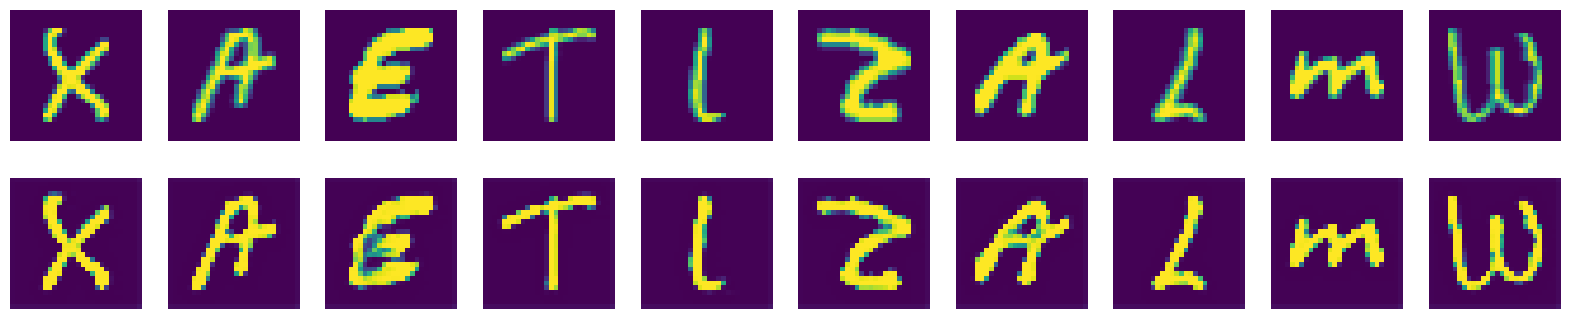

In [14]:

if INTERACTIVE_SESSION:
    display_sample_images(x_test, decoded_imgs[0], conf.img_shape)
    

In [15]:
model.evaluate(x=x_test)


   1/1801 [..............................] - ETA: 10:04 - loss: 0.0000e+00 - output0_loss: 0.0000e+00 - output1_loss: 0.0000e+00 - output2_loss: 0.0000e+00 - output3_loss: 0.0000e+00 - output4_loss: 0.0000e+00 - output5_loss: 0.0000e+00 - output0_accuracy: 0.0000e+00 - output0_f1_score: nan - output1_accuracy: 0.0000e+00 - output1_f1_score: nan - output2_accuracy: 0.0000e+00 - output2_f1_score: nan - output3_accuracy: 0.0000e+00 - output3_f1_score: nan - output4_accuracy: 0.0000e+00 - output4_f1_score: nan - output5_accuracy: 0.0000e+00 - output5_f1_score: nan

  29/1801 [..............................] - ETA: 3s - loss: 0.0000e+00 - output0_loss: 0.0000e+00 - output1_loss: 0.0000e+00 - output2_loss: 0.0000e+00 - output3_loss: 0.0000e+00 - output4_loss: 0.0000e+00 - output5_loss: 0.0000e+00 - output0_accuracy: 0.0000e+00 - output0_f1_score: nan - output1_accuracy: 0.0000e+00 - output1_f1_score: nan - output2_accuracy: 0.0000e+00 - output2_f1_score: nan - output3_accuracy: 0.0000e+00 - output3_f1_score: nan - output4_accuracy: 0.0000e+00 - output4_f1_score: nan - output5_accuracy: 0.0000e+00 - output5_f1_score: nan   

  60/1801 [..............................] - ETA: 2s - loss: 0.0000e+00 - output0_loss: 0.0000e+00 - output1_loss: 0.0000e+00 - output2_loss: 0.0000e+00 - output3_loss: 0.0000e+00 - output4_loss: 0.0000e+00 - output5_loss: 0.0000e+00 - output0_accuracy: 0.0000e+00 - output0_f1_score: nan - output1_accuracy: 0.0000e+00 - output1_f1_score: nan - output2_accuracy: 0.0000e+00 - output2_f1_score: nan - output3_accuracy: 0.0000e+00 - output3_f1_score: nan - output4_accuracy: 0.0000e+00 - output4_f1_score: nan - output5_accuracy: 0.0000e+00 - output5_f1_score: nan

  91/1801 [>.............................] - ETA: 2s - loss: 0.0000e+00 - output0_loss: 0.0000e+00 - output1_loss: 0.0000e+00 - output2_loss: 0.0000e+00 - output3_loss: 0.0000e+00 - output4_loss: 0.0000e+00 - output5_loss: 0.0000e+00 - output0_accuracy: 0.0000e+00 - output0_f1_score: nan - output1_accuracy: 0.0000e+00 - output1_f1_score: nan - output2_accuracy: 0.0000e+00 - output2_f1_score: nan - output3_accuracy: 0.0000e+00 - output3_f1_score: nan - output4_accuracy: 0.0000e+00 - output4_f1_score: nan - output5_accuracy: 0.0000e+00 - output5_f1_score: nan

 123/1801 [=>............................] - ETA: 2s - loss: 0.0000e+00 - output0_loss: 0.0000e+00 - output1_loss: 0.0000e+00 - output2_loss: 0.0000e+00 - output3_loss: 0.0000e+00 - output4_loss: 0.0000e+00 - output5_loss: 0.0000e+00 - output0_accuracy: 0.0000e+00 - output0_f1_score: nan - output1_accuracy: 0.0000e+00 - output1_f1_score: nan - output2_accuracy: 0.0000e+00 - output2_f1_score: nan - output3_accuracy: 0.0000e+00 - output3_f1_score: nan - output4_accuracy: 0.0000e+00 - output4_f1_score: nan - output5_accuracy: 0.0000e+00 - output5_f1_score: nan

 154/1801 [=>............................] - ETA: 2s - loss: 0.0000e+00 - output0_loss: 0.0000e+00 - output1_loss: 0.0000e+00 - output2_loss: 0.0000e+00 - output3_loss: 0.0000e+00 - output4_loss: 0.0000e+00 - output5_loss: 0.0000e+00 - output0_accuracy: 0.0000e+00 - output0_f1_score: nan - output1_accuracy: 0.0000e+00 - output1_f1_score: nan - output2_accuracy: 0.0000e+00 - output2_f1_score: nan - output3_accuracy: 0.0000e+00 - output3_f1_score: nan - output4_accuracy: 0.0000e+00 - output4_f1_score: nan - output5_accuracy: 0.0000e+00 - output5_f1_score: nan

 186/1801 [==>...........................] - ETA: 2s - loss: 0.0000e+00 - output0_loss: 0.0000e+00 - output1_loss: 0.0000e+00 - output2_loss: 0.0000e+00 - output3_loss: 0.0000e+00 - output4_loss: 0.0000e+00 - output5_loss: 0.0000e+00 - output0_accuracy: 0.0000e+00 - output0_f1_score: nan - output1_accuracy: 0.0000e+00 - output1_f1_score: nan - output2_accuracy: 0.0000e+00 - output2_f1_score: nan - output3_accuracy: 0.0000e+00 - output3_f1_score: nan - output4_accuracy: 0.0000e+00 - output4_f1_score: nan - output5_accuracy: 0.0000e+00 - output5_f1_score: nan

 218/1801 [==>...........................] - ETA: 2s - loss: 0.0000e+00 - output0_loss: 0.0000e+00 - output1_loss: 0.0000e+00 - output2_loss: 0.0000e+00 - output3_loss: 0.0000e+00 - output4_loss: 0.0000e+00 - output5_loss: 0.0000e+00 - output0_accuracy: 0.0000e+00 - output0_f1_score: nan - output1_accuracy: 0.0000e+00 - output1_f1_score: nan - output2_accuracy: 0.0000e+00 - output2_f1_score: nan - output3_accuracy: 0.0000e+00 - output3_f1_score: nan - output4_accuracy: 0.0000e+00 - output4_f1_score: nan - output5_accuracy: 0.0000e+00 - output5_f1_score: nan

 250/1801 [===>..........................] - ETA: 2s - loss: 0.0000e+00 - output0_loss: 0.0000e+00 - output1_loss: 0.0000e+00 - output2_loss: 0.0000e+00 - output3_loss: 0.0000e+00 - output4_loss: 0.0000e+00 - output5_loss: 0.0000e+00 - output0_accuracy: 0.0000e+00 - output0_f1_score: nan - output1_accuracy: 0.0000e+00 - output1_f1_score: nan - output2_accuracy: 0.0000e+00 - output2_f1_score: nan - output3_accuracy: 0.0000e+00 - output3_f1_score: nan - output4_accuracy: 0.0000e+00 - output4_f1_score: nan - output5_accuracy: 0.0000e+00 - output5_f1_score: nan

 282/1801 [===>..........................] - ETA: 2s - loss: 0.0000e+00 - output0_loss: 0.0000e+00 - output1_loss: 0.0000e+00 - output2_loss: 0.0000e+00 - output3_loss: 0.0000e+00 - output4_loss: 0.0000e+00 - output5_loss: 0.0000e+00 - output0_accuracy: 0.0000e+00 - output0_f1_score: nan - output1_accuracy: 0.0000e+00 - output1_f1_score: nan - output2_accuracy: 0.0000e+00 - output2_f1_score: nan - output3_accuracy: 0.0000e+00 - output3_f1_score: nan - output4_accuracy: 0.0000e+00 - output4_f1_score: nan - output5_accuracy: 0.0000e+00 - output5_f1_score: nan

 314/1801 [====>.........................] - ETA: 2s - loss: 0.0000e+00 - output0_loss: 0.0000e+00 - output1_loss: 0.0000e+00 - output2_loss: 0.0000e+00 - output3_loss: 0.0000e+00 - output4_loss: 0.0000e+00 - output5_loss: 0.0000e+00 - output0_accuracy: 0.0000e+00 - output0_f1_score: nan - output1_accuracy: 0.0000e+00 - output1_f1_score: nan - output2_accuracy: 0.0000e+00 - output2_f1_score: nan - output3_accuracy: 0.0000e+00 - output3_f1_score: nan - output4_accuracy: 0.0000e+00 - output4_f1_score: nan - output5_accuracy: 0.0000e+00 - output5_f1_score: nan

 345/1801 [====>.........................] - ETA: 2s - loss: 0.0000e+00 - output0_loss: 0.0000e+00 - output1_loss: 0.0000e+00 - output2_loss: 0.0000e+00 - output3_loss: 0.0000e+00 - output4_loss: 0.0000e+00 - output5_loss: 0.0000e+00 - output0_accuracy: 0.0000e+00 - output0_f1_score: nan - output1_accuracy: 0.0000e+00 - output1_f1_score: nan - output2_accuracy: 0.0000e+00 - output2_f1_score: nan - output3_accuracy: 0.0000e+00 - output3_f1_score: nan - output4_accuracy: 0.0000e+00 - output4_f1_score: nan - output5_accuracy: 0.0000e+00 - output5_f1_score: nan

 377/1801 [=====>........................] - ETA: 2s - loss: 0.0000e+00 - output0_loss: 0.0000e+00 - output1_loss: 0.0000e+00 - output2_loss: 0.0000e+00 - output3_loss: 0.0000e+00 - output4_loss: 0.0000e+00 - output5_loss: 0.0000e+00 - output0_accuracy: 0.0000e+00 - output0_f1_score: nan - output1_accuracy: 0.0000e+00 - output1_f1_score: nan - output2_accuracy: 0.0000e+00 - output2_f1_score: nan - output3_accuracy: 0.0000e+00 - output3_f1_score: nan - output4_accuracy: 0.0000e+00 - output4_f1_score: nan - output5_accuracy: 0.0000e+00 - output5_f1_score: nan

 409/1801 [=====>........................] - ETA: 2s - loss: 0.0000e+00 - output0_loss: 0.0000e+00 - output1_loss: 0.0000e+00 - output2_loss: 0.0000e+00 - output3_loss: 0.0000e+00 - output4_loss: 0.0000e+00 - output5_loss: 0.0000e+00 - output0_accuracy: 0.0000e+00 - output0_f1_score: nan - output1_accuracy: 0.0000e+00 - output1_f1_score: nan - output2_accuracy: 0.0000e+00 - output2_f1_score: nan - output3_accuracy: 0.0000e+00 - output3_f1_score: nan - output4_accuracy: 0.0000e+00 - output4_f1_score: nan - output5_accuracy: 0.0000e+00 - output5_f1_score: nan

 441/1801 [======>.......................] - ETA: 2s - loss: 0.0000e+00 - output0_loss: 0.0000e+00 - output1_loss: 0.0000e+00 - output2_loss: 0.0000e+00 - output3_loss: 0.0000e+00 - output4_loss: 0.0000e+00 - output5_loss: 0.0000e+00 - output0_accuracy: 0.0000e+00 - output0_f1_score: nan - output1_accuracy: 0.0000e+00 - output1_f1_score: nan - output2_accuracy: 0.0000e+00 - output2_f1_score: nan - output3_accuracy: 0.0000e+00 - output3_f1_score: nan - output4_accuracy: 0.0000e+00 - output4_f1_score: nan - output5_accuracy: 0.0000e+00 - output5_f1_score: nan

 472/1801 [======>.......................] - ETA: 2s - loss: 0.0000e+00 - output0_loss: 0.0000e+00 - output1_loss: 0.0000e+00 - output2_loss: 0.0000e+00 - output3_loss: 0.0000e+00 - output4_loss: 0.0000e+00 - output5_loss: 0.0000e+00 - output0_accuracy: 0.0000e+00 - output0_f1_score: nan - output1_accuracy: 0.0000e+00 - output1_f1_score: nan - output2_accuracy: 0.0000e+00 - output2_f1_score: nan - output3_accuracy: 0.0000e+00 - output3_f1_score: nan - output4_accuracy: 0.0000e+00 - output4_f1_score: nan - output5_accuracy: 0.0000e+00 - output5_f1_score: nan

 504/1801 [=======>......................] - ETA: 2s - loss: 0.0000e+00 - output0_loss: 0.0000e+00 - output1_loss: 0.0000e+00 - output2_loss: 0.0000e+00 - output3_loss: 0.0000e+00 - output4_loss: 0.0000e+00 - output5_loss: 0.0000e+00 - output0_accuracy: 0.0000e+00 - output0_f1_score: nan - output1_accuracy: 0.0000e+00 - output1_f1_score: nan - output2_accuracy: 0.0000e+00 - output2_f1_score: nan - output3_accuracy: 0.0000e+00 - output3_f1_score: nan - output4_accuracy: 0.0000e+00 - output4_f1_score: nan - output5_accuracy: 0.0000e+00 - output5_f1_score: nan

 536/1801 [=======>......................] - ETA: 2s - loss: 0.0000e+00 - output0_loss: 0.0000e+00 - output1_loss: 0.0000e+00 - output2_loss: 0.0000e+00 - output3_loss: 0.0000e+00 - output4_loss: 0.0000e+00 - output5_loss: 0.0000e+00 - output0_accuracy: 0.0000e+00 - output0_f1_score: nan - output1_accuracy: 0.0000e+00 - output1_f1_score: nan - output2_accuracy: 0.0000e+00 - output2_f1_score: nan - output3_accuracy: 0.0000e+00 - output3_f1_score: nan - output4_accuracy: 0.0000e+00 - output4_f1_score: nan - output5_accuracy: 0.0000e+00 - output5_f1_score: nan

 568/1801 [========>.....................] - ETA: 1s - loss: 0.0000e+00 - output0_loss: 0.0000e+00 - output1_loss: 0.0000e+00 - output2_loss: 0.0000e+00 - output3_loss: 0.0000e+00 - output4_loss: 0.0000e+00 - output5_loss: 0.0000e+00 - output0_accuracy: 0.0000e+00 - output0_f1_score: nan - output1_accuracy: 0.0000e+00 - output1_f1_score: nan - output2_accuracy: 0.0000e+00 - output2_f1_score: nan - output3_accuracy: 0.0000e+00 - output3_f1_score: nan - output4_accuracy: 0.0000e+00 - output4_f1_score: nan - output5_accuracy: 0.0000e+00 - output5_f1_score: nan

 600/1801 [========>.....................] - ETA: 1s - loss: 0.0000e+00 - output0_loss: 0.0000e+00 - output1_loss: 0.0000e+00 - output2_loss: 0.0000e+00 - output3_loss: 0.0000e+00 - output4_loss: 0.0000e+00 - output5_loss: 0.0000e+00 - output0_accuracy: 0.0000e+00 - output0_f1_score: nan - output1_accuracy: 0.0000e+00 - output1_f1_score: nan - output2_accuracy: 0.0000e+00 - output2_f1_score: nan - output3_accuracy: 0.0000e+00 - output3_f1_score: nan - output4_accuracy: 0.0000e+00 - output4_f1_score: nan - output5_accuracy: 0.0000e+00 - output5_f1_score: nan

 631/1801 [=========>....................] - ETA: 1s - loss: 0.0000e+00 - output0_loss: 0.0000e+00 - output1_loss: 0.0000e+00 - output2_loss: 0.0000e+00 - output3_loss: 0.0000e+00 - output4_loss: 0.0000e+00 - output5_loss: 0.0000e+00 - output0_accuracy: 0.0000e+00 - output0_f1_score: nan - output1_accuracy: 0.0000e+00 - output1_f1_score: nan - output2_accuracy: 0.0000e+00 - output2_f1_score: nan - output3_accuracy: 0.0000e+00 - output3_f1_score: nan - output4_accuracy: 0.0000e+00 - output4_f1_score: nan - output5_accuracy: 0.0000e+00 - output5_f1_score: nan

 663/1801 [==========>...................] - ETA: 1s - loss: 0.0000e+00 - output0_loss: 0.0000e+00 - output1_loss: 0.0000e+00 - output2_loss: 0.0000e+00 - output3_loss: 0.0000e+00 - output4_loss: 0.0000e+00 - output5_loss: 0.0000e+00 - output0_accuracy: 0.0000e+00 - output0_f1_score: nan - output1_accuracy: 0.0000e+00 - output1_f1_score: nan - output2_accuracy: 0.0000e+00 - output2_f1_score: nan - output3_accuracy: 0.0000e+00 - output3_f1_score: nan - output4_accuracy: 0.0000e+00 - output4_f1_score: nan - output5_accuracy: 0.0000e+00 - output5_f1_score: nan

 695/1801 [==========>...................] - ETA: 1s - loss: 0.0000e+00 - output0_loss: 0.0000e+00 - output1_loss: 0.0000e+00 - output2_loss: 0.0000e+00 - output3_loss: 0.0000e+00 - output4_loss: 0.0000e+00 - output5_loss: 0.0000e+00 - output0_accuracy: 0.0000e+00 - output0_f1_score: nan - output1_accuracy: 0.0000e+00 - output1_f1_score: nan - output2_accuracy: 0.0000e+00 - output2_f1_score: nan - output3_accuracy: 0.0000e+00 - output3_f1_score: nan - output4_accuracy: 0.0000e+00 - output4_f1_score: nan - output5_accuracy: 0.0000e+00 - output5_f1_score: nan

 727/1801 [===========>..................] - ETA: 1s - loss: 0.0000e+00 - output0_loss: 0.0000e+00 - output1_loss: 0.0000e+00 - output2_loss: 0.0000e+00 - output3_loss: 0.0000e+00 - output4_loss: 0.0000e+00 - output5_loss: 0.0000e+00 - output0_accuracy: 0.0000e+00 - output0_f1_score: nan - output1_accuracy: 0.0000e+00 - output1_f1_score: nan - output2_accuracy: 0.0000e+00 - output2_f1_score: nan - output3_accuracy: 0.0000e+00 - output3_f1_score: nan - output4_accuracy: 0.0000e+00 - output4_f1_score: nan - output5_accuracy: 0.0000e+00 - output5_f1_score: nan

 758/1801 [===========>..................] - ETA: 1s - loss: 0.0000e+00 - output0_loss: 0.0000e+00 - output1_loss: 0.0000e+00 - output2_loss: 0.0000e+00 - output3_loss: 0.0000e+00 - output4_loss: 0.0000e+00 - output5_loss: 0.0000e+00 - output0_accuracy: 0.0000e+00 - output0_f1_score: nan - output1_accuracy: 0.0000e+00 - output1_f1_score: nan - output2_accuracy: 0.0000e+00 - output2_f1_score: nan - output3_accuracy: 0.0000e+00 - output3_f1_score: nan - output4_accuracy: 0.0000e+00 - output4_f1_score: nan - output5_accuracy: 0.0000e+00 - output5_f1_score: nan

 789/1801 [============>.................] - ETA: 1s - loss: 0.0000e+00 - output0_loss: 0.0000e+00 - output1_loss: 0.0000e+00 - output2_loss: 0.0000e+00 - output3_loss: 0.0000e+00 - output4_loss: 0.0000e+00 - output5_loss: 0.0000e+00 - output0_accuracy: 0.0000e+00 - output0_f1_score: nan - output1_accuracy: 0.0000e+00 - output1_f1_score: nan - output2_accuracy: 0.0000e+00 - output2_f1_score: nan - output3_accuracy: 0.0000e+00 - output3_f1_score: nan - output4_accuracy: 0.0000e+00 - output4_f1_score: nan - output5_accuracy: 0.0000e+00 - output5_f1_score: nan

 820/1801 [============>.................] - ETA: 1s - loss: 0.0000e+00 - output0_loss: 0.0000e+00 - output1_loss: 0.0000e+00 - output2_loss: 0.0000e+00 - output3_loss: 0.0000e+00 - output4_loss: 0.0000e+00 - output5_loss: 0.0000e+00 - output0_accuracy: 0.0000e+00 - output0_f1_score: nan - output1_accuracy: 0.0000e+00 - output1_f1_score: nan - output2_accuracy: 0.0000e+00 - output2_f1_score: nan - output3_accuracy: 0.0000e+00 - output3_f1_score: nan - output4_accuracy: 0.0000e+00 - output4_f1_score: nan - output5_accuracy: 0.0000e+00 - output5_f1_score: nan

 850/1801 [=============>................] - ETA: 1s - loss: 0.0000e+00 - output0_loss: 0.0000e+00 - output1_loss: 0.0000e+00 - output2_loss: 0.0000e+00 - output3_loss: 0.0000e+00 - output4_loss: 0.0000e+00 - output5_loss: 0.0000e+00 - output0_accuracy: 0.0000e+00 - output0_f1_score: nan - output1_accuracy: 0.0000e+00 - output1_f1_score: nan - output2_accuracy: 0.0000e+00 - output2_f1_score: nan - output3_accuracy: 0.0000e+00 - output3_f1_score: nan - output4_accuracy: 0.0000e+00 - output4_f1_score: nan - output5_accuracy: 0.0000e+00 - output5_f1_score: nan

 881/1801 [=============>................] - ETA: 1s - loss: 0.0000e+00 - output0_loss: 0.0000e+00 - output1_loss: 0.0000e+00 - output2_loss: 0.0000e+00 - output3_loss: 0.0000e+00 - output4_loss: 0.0000e+00 - output5_loss: 0.0000e+00 - output0_accuracy: 0.0000e+00 - output0_f1_score: nan - output1_accuracy: 0.0000e+00 - output1_f1_score: nan - output2_accuracy: 0.0000e+00 - output2_f1_score: nan - output3_accuracy: 0.0000e+00 - output3_f1_score: nan - output4_accuracy: 0.0000e+00 - output4_f1_score: nan - output5_accuracy: 0.0000e+00 - output5_f1_score: nan

 913/1801 [==============>...............] - ETA: 1s - loss: 0.0000e+00 - output0_loss: 0.0000e+00 - output1_loss: 0.0000e+00 - output2_loss: 0.0000e+00 - output3_loss: 0.0000e+00 - output4_loss: 0.0000e+00 - output5_loss: 0.0000e+00 - output0_accuracy: 0.0000e+00 - output0_f1_score: nan - output1_accuracy: 0.0000e+00 - output1_f1_score: nan - output2_accuracy: 0.0000e+00 - output2_f1_score: nan - output3_accuracy: 0.0000e+00 - output3_f1_score: nan - output4_accuracy: 0.0000e+00 - output4_f1_score: nan - output5_accuracy: 0.0000e+00 - output5_f1_score: nan

 945/1801 [==============>...............] - ETA: 1s - loss: 0.0000e+00 - output0_loss: 0.0000e+00 - output1_loss: 0.0000e+00 - output2_loss: 0.0000e+00 - output3_loss: 0.0000e+00 - output4_loss: 0.0000e+00 - output5_loss: 0.0000e+00 - output0_accuracy: 0.0000e+00 - output0_f1_score: nan - output1_accuracy: 0.0000e+00 - output1_f1_score: nan - output2_accuracy: 0.0000e+00 - output2_f1_score: nan - output3_accuracy: 0.0000e+00 - output3_f1_score: nan - output4_accuracy: 0.0000e+00 - output4_f1_score: nan - output5_accuracy: 0.0000e+00 - output5_f1_score: nan

 977/1801 [===============>..............] - ETA: 1s - loss: 0.0000e+00 - output0_loss: 0.0000e+00 - output1_loss: 0.0000e+00 - output2_loss: 0.0000e+00 - output3_loss: 0.0000e+00 - output4_loss: 0.0000e+00 - output5_loss: 0.0000e+00 - output0_accuracy: 0.0000e+00 - output0_f1_score: nan - output1_accuracy: 0.0000e+00 - output1_f1_score: nan - output2_accuracy: 0.0000e+00 - output2_f1_score: nan - output3_accuracy: 0.0000e+00 - output3_f1_score: nan - output4_accuracy: 0.0000e+00 - output4_f1_score: nan - output5_accuracy: 0.0000e+00 - output5_f1_score: nan

1008/1801 [===============>..............] - ETA: 1s - loss: 0.0000e+00 - output0_loss: 0.0000e+00 - output1_loss: 0.0000e+00 - output2_loss: 0.0000e+00 - output3_loss: 0.0000e+00 - output4_loss: 0.0000e+00 - output5_loss: 0.0000e+00 - output0_accuracy: 0.0000e+00 - output0_f1_score: nan - output1_accuracy: 0.0000e+00 - output1_f1_score: nan - output2_accuracy: 0.0000e+00 - output2_f1_score: nan - output3_accuracy: 0.0000e+00 - output3_f1_score: nan - output4_accuracy: 0.0000e+00 - output4_f1_score: nan - output5_accuracy: 0.0000e+00 - output5_f1_score: nan

1040/1801 [================>.............] - ETA: 1s - loss: 0.0000e+00 - output0_loss: 0.0000e+00 - output1_loss: 0.0000e+00 - output2_loss: 0.0000e+00 - output3_loss: 0.0000e+00 - output4_loss: 0.0000e+00 - output5_loss: 0.0000e+00 - output0_accuracy: 0.0000e+00 - output0_f1_score: nan - output1_accuracy: 0.0000e+00 - output1_f1_score: nan - output2_accuracy: 0.0000e+00 - output2_f1_score: nan - output3_accuracy: 0.0000e+00 - output3_f1_score: nan - output4_accuracy: 0.0000e+00 - output4_f1_score: nan - output5_accuracy: 0.0000e+00 - output5_f1_score: nan

1073/1801 [================>.............] - ETA: 1s - loss: 0.0000e+00 - output0_loss: 0.0000e+00 - output1_loss: 0.0000e+00 - output2_loss: 0.0000e+00 - output3_loss: 0.0000e+00 - output4_loss: 0.0000e+00 - output5_loss: 0.0000e+00 - output0_accuracy: 0.0000e+00 - output0_f1_score: nan - output1_accuracy: 0.0000e+00 - output1_f1_score: nan - output2_accuracy: 0.0000e+00 - output2_f1_score: nan - output3_accuracy: 0.0000e+00 - output3_f1_score: nan - output4_accuracy: 0.0000e+00 - output4_f1_score: nan - output5_accuracy: 0.0000e+00 - output5_f1_score: nan

1106/1801 [=================>............] - ETA: 1s - loss: 0.0000e+00 - output0_loss: 0.0000e+00 - output1_loss: 0.0000e+00 - output2_loss: 0.0000e+00 - output3_loss: 0.0000e+00 - output4_loss: 0.0000e+00 - output5_loss: 0.0000e+00 - output0_accuracy: 0.0000e+00 - output0_f1_score: nan - output1_accuracy: 0.0000e+00 - output1_f1_score: nan - output2_accuracy: 0.0000e+00 - output2_f1_score: nan - output3_accuracy: 0.0000e+00 - output3_f1_score: nan - output4_accuracy: 0.0000e+00 - output4_f1_score: nan - output5_accuracy: 0.0000e+00 - output5_f1_score: nan

1139/1801 [=================>............] - ETA: 1s - loss: 0.0000e+00 - output0_loss: 0.0000e+00 - output1_loss: 0.0000e+00 - output2_loss: 0.0000e+00 - output3_loss: 0.0000e+00 - output4_loss: 0.0000e+00 - output5_loss: 0.0000e+00 - output0_accuracy: 0.0000e+00 - output0_f1_score: nan - output1_accuracy: 0.0000e+00 - output1_f1_score: nan - output2_accuracy: 0.0000e+00 - output2_f1_score: nan - output3_accuracy: 0.0000e+00 - output3_f1_score: nan - output4_accuracy: 0.0000e+00 - output4_f1_score: nan - output5_accuracy: 0.0000e+00 - output5_f1_score: nan

1171/1801 [==================>...........] - ETA: 1s - loss: 0.0000e+00 - output0_loss: 0.0000e+00 - output1_loss: 0.0000e+00 - output2_loss: 0.0000e+00 - output3_loss: 0.0000e+00 - output4_loss: 0.0000e+00 - output5_loss: 0.0000e+00 - output0_accuracy: 0.0000e+00 - output0_f1_score: nan - output1_accuracy: 0.0000e+00 - output1_f1_score: nan - output2_accuracy: 0.0000e+00 - output2_f1_score: nan - output3_accuracy: 0.0000e+00 - output3_f1_score: nan - output4_accuracy: 0.0000e+00 - output4_f1_score: nan - output5_accuracy: 0.0000e+00 - output5_f1_score: nan

1204/1801 [===================>..........] - ETA: 0s - loss: 0.0000e+00 - output0_loss: 0.0000e+00 - output1_loss: 0.0000e+00 - output2_loss: 0.0000e+00 - output3_loss: 0.0000e+00 - output4_loss: 0.0000e+00 - output5_loss: 0.0000e+00 - output0_accuracy: 0.0000e+00 - output0_f1_score: nan - output1_accuracy: 0.0000e+00 - output1_f1_score: nan - output2_accuracy: 0.0000e+00 - output2_f1_score: nan - output3_accuracy: 0.0000e+00 - output3_f1_score: nan - output4_accuracy: 0.0000e+00 - output4_f1_score: nan - output5_accuracy: 0.0000e+00 - output5_f1_score: nan

1237/1801 [===================>..........] - ETA: 0s - loss: 0.0000e+00 - output0_loss: 0.0000e+00 - output1_loss: 0.0000e+00 - output2_loss: 0.0000e+00 - output3_loss: 0.0000e+00 - output4_loss: 0.0000e+00 - output5_loss: 0.0000e+00 - output0_accuracy: 0.0000e+00 - output0_f1_score: nan - output1_accuracy: 0.0000e+00 - output1_f1_score: nan - output2_accuracy: 0.0000e+00 - output2_f1_score: nan - output3_accuracy: 0.0000e+00 - output3_f1_score: nan - output4_accuracy: 0.0000e+00 - output4_f1_score: nan - output5_accuracy: 0.0000e+00 - output5_f1_score: nan

1270/1801 [====================>.........] - ETA: 0s - loss: 0.0000e+00 - output0_loss: 0.0000e+00 - output1_loss: 0.0000e+00 - output2_loss: 0.0000e+00 - output3_loss: 0.0000e+00 - output4_loss: 0.0000e+00 - output5_loss: 0.0000e+00 - output0_accuracy: 0.0000e+00 - output0_f1_score: nan - output1_accuracy: 0.0000e+00 - output1_f1_score: nan - output2_accuracy: 0.0000e+00 - output2_f1_score: nan - output3_accuracy: 0.0000e+00 - output3_f1_score: nan - output4_accuracy: 0.0000e+00 - output4_f1_score: nan - output5_accuracy: 0.0000e+00 - output5_f1_score: nan

1302/1801 [====================>.........] - ETA: 0s - loss: 0.0000e+00 - output0_loss: 0.0000e+00 - output1_loss: 0.0000e+00 - output2_loss: 0.0000e+00 - output3_loss: 0.0000e+00 - output4_loss: 0.0000e+00 - output5_loss: 0.0000e+00 - output0_accuracy: 0.0000e+00 - output0_f1_score: nan - output1_accuracy: 0.0000e+00 - output1_f1_score: nan - output2_accuracy: 0.0000e+00 - output2_f1_score: nan - output3_accuracy: 0.0000e+00 - output3_f1_score: nan - output4_accuracy: 0.0000e+00 - output4_f1_score: nan - output5_accuracy: 0.0000e+00 - output5_f1_score: nan

1333/1801 [=====================>........] - ETA: 0s - loss: 0.0000e+00 - output0_loss: 0.0000e+00 - output1_loss: 0.0000e+00 - output2_loss: 0.0000e+00 - output3_loss: 0.0000e+00 - output4_loss: 0.0000e+00 - output5_loss: 0.0000e+00 - output0_accuracy: 0.0000e+00 - output0_f1_score: nan - output1_accuracy: 0.0000e+00 - output1_f1_score: nan - output2_accuracy: 0.0000e+00 - output2_f1_score: nan - output3_accuracy: 0.0000e+00 - output3_f1_score: nan - output4_accuracy: 0.0000e+00 - output4_f1_score: nan - output5_accuracy: 0.0000e+00 - output5_f1_score: nan

1364/1801 [=====================>........] - ETA: 0s - loss: 0.0000e+00 - output0_loss: 0.0000e+00 - output1_loss: 0.0000e+00 - output2_loss: 0.0000e+00 - output3_loss: 0.0000e+00 - output4_loss: 0.0000e+00 - output5_loss: 0.0000e+00 - output0_accuracy: 0.0000e+00 - output0_f1_score: nan - output1_accuracy: 0.0000e+00 - output1_f1_score: nan - output2_accuracy: 0.0000e+00 - output2_f1_score: nan - output3_accuracy: 0.0000e+00 - output3_f1_score: nan - output4_accuracy: 0.0000e+00 - output4_f1_score: nan - output5_accuracy: 0.0000e+00 - output5_f1_score: nan

1393/1801 [======================>.......] - ETA: 0s - loss: 0.0000e+00 - output0_loss: 0.0000e+00 - output1_loss: 0.0000e+00 - output2_loss: 0.0000e+00 - output3_loss: 0.0000e+00 - output4_loss: 0.0000e+00 - output5_loss: 0.0000e+00 - output0_accuracy: 0.0000e+00 - output0_f1_score: nan - output1_accuracy: 0.0000e+00 - output1_f1_score: nan - output2_accuracy: 0.0000e+00 - output2_f1_score: nan - output3_accuracy: 0.0000e+00 - output3_f1_score: nan - output4_accuracy: 0.0000e+00 - output4_f1_score: nan - output5_accuracy: 0.0000e+00 - output5_f1_score: nan

1424/1801 [======================>.......] - ETA: 0s - loss: 0.0000e+00 - output0_loss: 0.0000e+00 - output1_loss: 0.0000e+00 - output2_loss: 0.0000e+00 - output3_loss: 0.0000e+00 - output4_loss: 0.0000e+00 - output5_loss: 0.0000e+00 - output0_accuracy: 0.0000e+00 - output0_f1_score: nan - output1_accuracy: 0.0000e+00 - output1_f1_score: nan - output2_accuracy: 0.0000e+00 - output2_f1_score: nan - output3_accuracy: 0.0000e+00 - output3_f1_score: nan - output4_accuracy: 0.0000e+00 - output4_f1_score: nan - output5_accuracy: 0.0000e+00 - output5_f1_score: nan

1456/1801 [=======================>......] - ETA: 0s - loss: 0.0000e+00 - output0_loss: 0.0000e+00 - output1_loss: 0.0000e+00 - output2_loss: 0.0000e+00 - output3_loss: 0.0000e+00 - output4_loss: 0.0000e+00 - output5_loss: 0.0000e+00 - output0_accuracy: 0.0000e+00 - output0_f1_score: nan - output1_accuracy: 0.0000e+00 - output1_f1_score: nan - output2_accuracy: 0.0000e+00 - output2_f1_score: nan - output3_accuracy: 0.0000e+00 - output3_f1_score: nan - output4_accuracy: 0.0000e+00 - output4_f1_score: nan - output5_accuracy: 0.0000e+00 - output5_f1_score: nan

1489/1801 [=======================>......] - ETA: 0s - loss: 0.0000e+00 - output0_loss: 0.0000e+00 - output1_loss: 0.0000e+00 - output2_loss: 0.0000e+00 - output3_loss: 0.0000e+00 - output4_loss: 0.0000e+00 - output5_loss: 0.0000e+00 - output0_accuracy: 0.0000e+00 - output0_f1_score: nan - output1_accuracy: 0.0000e+00 - output1_f1_score: nan - output2_accuracy: 0.0000e+00 - output2_f1_score: nan - output3_accuracy: 0.0000e+00 - output3_f1_score: nan - output4_accuracy: 0.0000e+00 - output4_f1_score: nan - output5_accuracy: 0.0000e+00 - output5_f1_score: nan

1521/1801 [========================>.....] - ETA: 0s - loss: 0.0000e+00 - output0_loss: 0.0000e+00 - output1_loss: 0.0000e+00 - output2_loss: 0.0000e+00 - output3_loss: 0.0000e+00 - output4_loss: 0.0000e+00 - output5_loss: 0.0000e+00 - output0_accuracy: 0.0000e+00 - output0_f1_score: nan - output1_accuracy: 0.0000e+00 - output1_f1_score: nan - output2_accuracy: 0.0000e+00 - output2_f1_score: nan - output3_accuracy: 0.0000e+00 - output3_f1_score: nan - output4_accuracy: 0.0000e+00 - output4_f1_score: nan - output5_accuracy: 0.0000e+00 - output5_f1_score: nan

1554/1801 [========================>.....] - ETA: 0s - loss: 0.0000e+00 - output0_loss: 0.0000e+00 - output1_loss: 0.0000e+00 - output2_loss: 0.0000e+00 - output3_loss: 0.0000e+00 - output4_loss: 0.0000e+00 - output5_loss: 0.0000e+00 - output0_accuracy: 0.0000e+00 - output0_f1_score: nan - output1_accuracy: 0.0000e+00 - output1_f1_score: nan - output2_accuracy: 0.0000e+00 - output2_f1_score: nan - output3_accuracy: 0.0000e+00 - output3_f1_score: nan - output4_accuracy: 0.0000e+00 - output4_f1_score: nan - output5_accuracy: 0.0000e+00 - output5_f1_score: nan

1586/1801 [=========================>....] - ETA: 0s - loss: 0.0000e+00 - output0_loss: 0.0000e+00 - output1_loss: 0.0000e+00 - output2_loss: 0.0000e+00 - output3_loss: 0.0000e+00 - output4_loss: 0.0000e+00 - output5_loss: 0.0000e+00 - output0_accuracy: 0.0000e+00 - output0_f1_score: nan - output1_accuracy: 0.0000e+00 - output1_f1_score: nan - output2_accuracy: 0.0000e+00 - output2_f1_score: nan - output3_accuracy: 0.0000e+00 - output3_f1_score: nan - output4_accuracy: 0.0000e+00 - output4_f1_score: nan - output5_accuracy: 0.0000e+00 - output5_f1_score: nan

1617/1801 [=========================>....] - ETA: 0s - loss: 0.0000e+00 - output0_loss: 0.0000e+00 - output1_loss: 0.0000e+00 - output2_loss: 0.0000e+00 - output3_loss: 0.0000e+00 - output4_loss: 0.0000e+00 - output5_loss: 0.0000e+00 - output0_accuracy: 0.0000e+00 - output0_f1_score: nan - output1_accuracy: 0.0000e+00 - output1_f1_score: nan - output2_accuracy: 0.0000e+00 - output2_f1_score: nan - output3_accuracy: 0.0000e+00 - output3_f1_score: nan - output4_accuracy: 0.0000e+00 - output4_f1_score: nan - output5_accuracy: 0.0000e+00 - output5_f1_score: nan

1649/1801 [==========================>...] - ETA: 0s - loss: 0.0000e+00 - output0_loss: 0.0000e+00 - output1_loss: 0.0000e+00 - output2_loss: 0.0000e+00 - output3_loss: 0.0000e+00 - output4_loss: 0.0000e+00 - output5_loss: 0.0000e+00 - output0_accuracy: 0.0000e+00 - output0_f1_score: nan - output1_accuracy: 0.0000e+00 - output1_f1_score: nan - output2_accuracy: 0.0000e+00 - output2_f1_score: nan - output3_accuracy: 0.0000e+00 - output3_f1_score: nan - output4_accuracy: 0.0000e+00 - output4_f1_score: nan - output5_accuracy: 0.0000e+00 - output5_f1_score: nan

1679/1801 [==========================>...] - ETA: 0s - loss: 0.0000e+00 - output0_loss: 0.0000e+00 - output1_loss: 0.0000e+00 - output2_loss: 0.0000e+00 - output3_loss: 0.0000e+00 - output4_loss: 0.0000e+00 - output5_loss: 0.0000e+00 - output0_accuracy: 0.0000e+00 - output0_f1_score: nan - output1_accuracy: 0.0000e+00 - output1_f1_score: nan - output2_accuracy: 0.0000e+00 - output2_f1_score: nan - output3_accuracy: 0.0000e+00 - output3_f1_score: nan - output4_accuracy: 0.0000e+00 - output4_f1_score: nan - output5_accuracy: 0.0000e+00 - output5_f1_score: nan

1710/1801 [===========================>..] - ETA: 0s - loss: 0.0000e+00 - output0_loss: 0.0000e+00 - output1_loss: 0.0000e+00 - output2_loss: 0.0000e+00 - output3_loss: 0.0000e+00 - output4_loss: 0.0000e+00 - output5_loss: 0.0000e+00 - output0_accuracy: 0.0000e+00 - output0_f1_score: nan - output1_accuracy: 0.0000e+00 - output1_f1_score: nan - output2_accuracy: 0.0000e+00 - output2_f1_score: nan - output3_accuracy: 0.0000e+00 - output3_f1_score: nan - output4_accuracy: 0.0000e+00 - output4_f1_score: nan - output5_accuracy: 0.0000e+00 - output5_f1_score: nan

1742/1801 [============================>.] - ETA: 0s - loss: 0.0000e+00 - output0_loss: 0.0000e+00 - output1_loss: 0.0000e+00 - output2_loss: 0.0000e+00 - output3_loss: 0.0000e+00 - output4_loss: 0.0000e+00 - output5_loss: 0.0000e+00 - output0_accuracy: 0.0000e+00 - output0_f1_score: nan - output1_accuracy: 0.0000e+00 - output1_f1_score: nan - output2_accuracy: 0.0000e+00 - output2_f1_score: nan - output3_accuracy: 0.0000e+00 - output3_f1_score: nan - output4_accuracy: 0.0000e+00 - output4_f1_score: nan - output5_accuracy: 0.0000e+00 - output5_f1_score: nan

1774/1801 [============================>.] - ETA: 0s - loss: 0.0000e+00 - output0_loss: 0.0000e+00 - output1_loss: 0.0000e+00 - output2_loss: 0.0000e+00 - output3_loss: 0.0000e+00 - output4_loss: 0.0000e+00 - output5_loss: 0.0000e+00 - output0_accuracy: 0.0000e+00 - output0_f1_score: nan - output1_accuracy: 0.0000e+00 - output1_f1_score: nan - output2_accuracy: 0.0000e+00 - output2_f1_score: nan - output3_accuracy: 0.0000e+00 - output3_f1_score: nan - output4_accuracy: 0.0000e+00 - output4_f1_score: nan - output5_accuracy: 0.0000e+00 - output5_f1_score: nan

1801/1801 [==============================] - 3s 2ms/step - loss: 0.0000e+00 - output0_loss: 0.0000e+00 - output1_loss: 0.0000e+00 - output2_loss: 0.0000e+00 - output3_loss: 0.0000e+00 - output4_loss: 0.0000e+00 - output5_loss: 0.0000e+00 - output0_accuracy: 0.0000e+00 - output0_f1_score: nan - output1_accuracy: 0.0000e+00 - output1_f1_score: nan - output2_accuracy: 0.0000e+00 - output2_f1_score: nan - output3_accuracy: 0.0000e+00 - output3_f1_score: nan - output4_accuracy: 0.0000e+00 - output4_f1_score: nan - output5_accuracy: 0.0000e+00 - output5_f1_score: nan


[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 nan,
 0.0,
 nan,
 0.0,
 nan,
 0.0,
 nan,
 0.0,
 nan,
 0.0,
 nan]

In [16]:

scores = conf.evaluate_sklearn(y_test, decoded_imgs[0],report=True)
print(scores)

evaluation elapsed time:___ 1.40___minutes
                     0           1  accuracy    macro avg  weighted avg
precision         1.00        0.38      0.78         0.69          0.92
recall            0.75        1.00      0.78         0.87          0.78
f1-score          0.86        0.55      0.78         0.70          0.82
support    39130264.00  6032056.00      0.78  45162320.00   45162320.00
{'Avg-precision': 0.98, 'f1-score(ODS)': 0.55}
